# Projet pratique en python : Credit scoring


In [106]:
# if u r using colab u can upload gro.csv
from google.colab import files
uploaded = files.upload()

Saving gro.csv to gro (1).csv


Nous allons travailler sur le jeu de données `gro.csv` pour faire du **credit scoring**, qui a été proposé il y a quelques années sur un site de data challenge. C'est un vrai de jeu qui contient des données avec différents types de variable, des valeurs manquantes, etc. Nous devons donc faire un gros travail de préparation de données.
Les données contiennent les colonnes suivantes :

| Nom de la colonne    | Description |
|:---------------------|:------------|
| BirthDate            | Date of birth of the client |
| Customer_Open_Date   | Creation date of the client's first account at the bank |
| Customer_Type        | Type of client (existing / new) | 
| Educational_Level    | Highest diploma |
| Id_Customer          | Id of the client |
| Marital_Status       | Family situation |
| Nb_Of_Products       | Number of products held by the client |
| Net_Annual_Income    | Annual revenue |
| Number_Of_Dependant  | Number of dependents |
| P_Client             | Non-disclosed feature |
| Prod_Category        | Product category |
| Prod_Closed_Date     | Closing date of the last product |
| Prod_Decision_Date   | Decision date of the last agreement for a financing product |
| Prod_Sub_Category    | Sub-category of the product |
| Source               | Financing source (Branch or Sales) |
| Type_Of_Residence    | Residential situation |
| Y                    | Credit was granted (yes / no) |
| Years_At_Business    | Number of year at the current job position |
| Years_At_Residence   | Number of year at the current housing |

Dans ce projet, l'objectif est de prédire la réponse Y (Credit was granted yes / no) en fonction des autres prédicteurs. Vous pourrez utiliser les méthodes de classification vues en cours (régression logistique / régression logistique pénalisée). Vous serez évalués sur plusieurs étapes :

* Préparer le jeu de données : complétion des données manquantes, détermination du type de chaque feature, création de la matrice de design et du vecteur de réponse.

* Entraînement de plusieurs modèles de régression logistique, avec ou sans pénalité, essai de différentes pénalisation, choix des hyper-paramètres

* Comparaison des résultats obtenus et conclusion.

Pour la prise en compte des données manquantes, voici ci-dessous quelques pistes.


On commence par importer les données via `pd.read_csv` en changeant le séparateur par défaut.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


import datetime
from datetime import date, timedelta, datetime
from pandas import Timestamp
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_context("notebook", font_scale=1.2)


In [108]:
gro_dtypes = {
    'Years_At_Residence': np.int,
    'Net_Annual_Income' : np.float,
    'Years_At_Business': np.float,
    'Number_Of_Dependant': np.float,
    'Nb_Of_Products': np.int,
    'Customer_Type': 'category',
    'P_Client': 'category',
    'Educational_Level': 'category',
    'Marital_Status': 'category',
    'Prod_Sub_Category': 'category',
    'Source': 'category',
    'Type_Of_Residence': 'category',
    'Prod_Category': 'category',
}

df = pd.read_csv(
    # Filename
    "gro.csv",
    # Column separator
    sep=';',
    # Decimal separator
    decimal=',',
    # Range of the columns to keep (remove the last three ones)
    usecols=range(19),
    # Which columns should be parsed as dates
    parse_dates=['BirthDate', 'Customer_Open_Date', 'Prod_Decision_Date', 
                 'Prod_Closed_Date'],
    # Specify some dtypes
    dtype=gro_dtypes
)

In [209]:
df.head(n=5)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,6714,0,Non Existing Client,1971-02-09,2012-01-18,NP_Client,University,Married,3.0,10,36.0,3.0,C,2012-01-23,Sales,Owned,1,NaT,B
1,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36.0,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
2,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18.0,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
3,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36.0,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
4,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36.0,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L


In [6]:
df.shape

(6725, 19)

Our data conatins 6725 observations and 19 variables.

## Data Cleaning


In [109]:
df.isnull().sum()

Id_Customer               0
Y                         0
Customer_Type             0
BirthDate                 0
Customer_Open_Date        0
P_Client                  0
Educational_Level         0
Marital_Status            0
Number_Of_Dependant       2
Years_At_Residence        0
Net_Annual_Income         3
Years_At_Business         4
Prod_Sub_Category         0
Prod_Decision_Date        0
Source                    0
Type_Of_Residence         0
Nb_Of_Products            0
Prod_Closed_Date       5291
Prod_Category             0
dtype: int64

C'est sur la colonne `Prod_Closed_Date` que se trouvent le plus grand nombre de valeurs manquantes, une solution est de la retirer. On peut également créer une nouvelle variable qui indique si `Prod_Closed_Date`est manquant ou non

In [110]:
# we ll replace Prod_Closed_Date by the columns that determines if it s missng or not

df ['Prod_Closed_Date'] = df[['Prod_Closed_Date']].isnull()

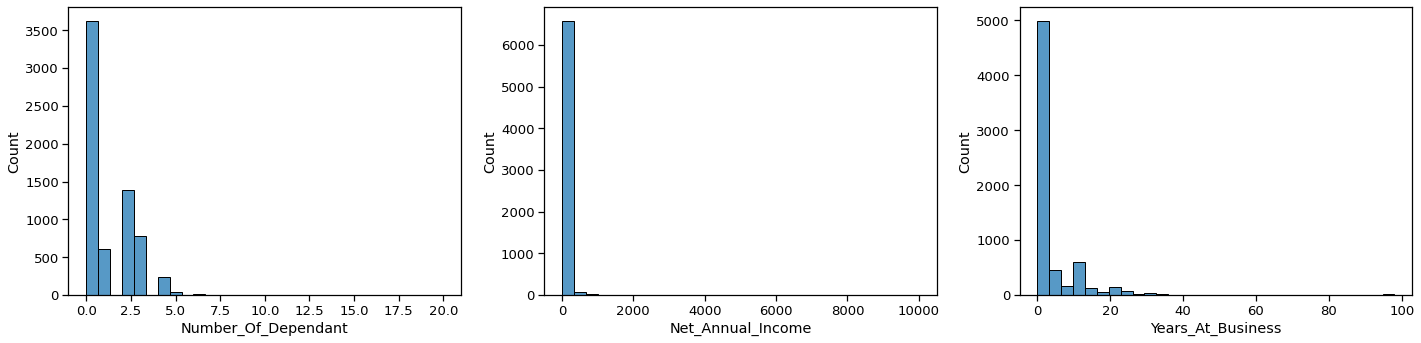

In [111]:
# for Number_Of_Dependant, Net_Annual_Income & Years_At_Business lets see how they r distributed and then decide the missing values imputation method

f, axes = plt.subplots(1, 3, figsize=(20,5))

sns.histplot(df.Number_Of_Dependant, bins = 30, ax=axes[0])
sns.histplot(df.Net_Annual_Income, bins = 30, ax=axes[1])
sns.histplot(df.Years_At_Business,  bins = 30, ax=axes[2])

f.tight_layout()

As we can see, the three distributions are skewed. Imputation with median would be better

In [112]:
# imptation with median

df['Number_Of_Dependant'].fillna((df.Number_Of_Dependant.median()), inplace=True)
df['Net_Annual_Income'].fillna((df.Net_Annual_Income.median()), inplace=True)
df['Years_At_Business'].fillna((df.Years_At_Business.median()), inplace=True)

In [113]:
# missing values double check
df.isnull().sum()

Id_Customer            0
Y                      0
Customer_Type          0
BirthDate              0
Customer_Open_Date     0
P_Client               0
Educational_Level      0
Marital_Status         0
Number_Of_Dependant    0
Years_At_Residence     0
Net_Annual_Income      0
Years_At_Business      0
Prod_Sub_Category      0
Prod_Decision_Date     0
Source                 0
Type_Of_Residence      0
Nb_Of_Products         0
Prod_Closed_Date       0
Prod_Category          0
dtype: int64




## Data Exploration 





In [114]:
# featues infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6725 entries, 0 to 6724
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id_Customer          6725 non-null   int64         
 1   Y                    6725 non-null   int64         
 2   Customer_Type        6725 non-null   category      
 3   BirthDate            6725 non-null   datetime64[ns]
 4   Customer_Open_Date   6725 non-null   datetime64[ns]
 5   P_Client             6725 non-null   category      
 6   Educational_Level    6725 non-null   category      
 7   Marital_Status       6725 non-null   category      
 8   Number_Of_Dependant  6725 non-null   float64       
 9   Years_At_Residence   6725 non-null   int64         
 10  Net_Annual_Income    6725 non-null   float64       
 11  Years_At_Business    6725 non-null   float64       
 12  Prod_Sub_Category    6725 non-null   category      
 13  Prod_Decision_Date   6725 non-nul

In [115]:
# balance check
df.groupby('Y')['Id_Customer'].count()

Y
0    6235
1     490
Name: Id_Customer, dtype: int64

Distribution of the target:


0    0.927138
1    0.072862
Name: Y, dtype: float64

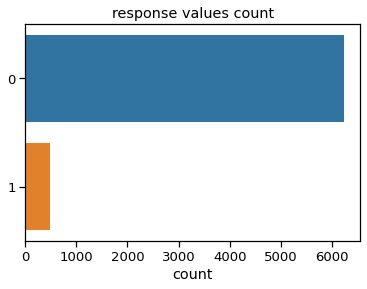

In [116]:
# response distribution

ax = sns.countplot(y=df.Y.values).set(title='response values count')


print('Distribution of the target:')
df.Y.value_counts()/df.shape[0]

Imbalanced problem :
the original dataframe is heavily imbalanced! Using the original dataframe will cause overfitting which means that our classification models will assume that in most cases there are no/0.

In [117]:
# numeric vars stats

df.iloc[:,1:].describe()

,Y,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Nb_Of_Products
count,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000
mean,0.072862,1.051301,12.564758,60.931821,4.263792,1.086840
std,0.259930,1.332637,9.986257,235.817837,7.253833,0.295033
min,0.000000,0.000000,0.000000,0.001000,0.000000,1.000000
25%,0.000000,0.000000,4.000000,20.000000,1.000000,1.000000
50%,0.000000,0.000000,10.000000,36.000000,1.000000,1.000000
75%,0.000000,2.000000,17.000000,36.000000,4.000000,1.000000
max,1.000000,20.000000,73.000000,10000.000000,98.000000,3.000000


Since the mean changes from a varibales to another between 1 and 60, therefore a scaling should be done on the data

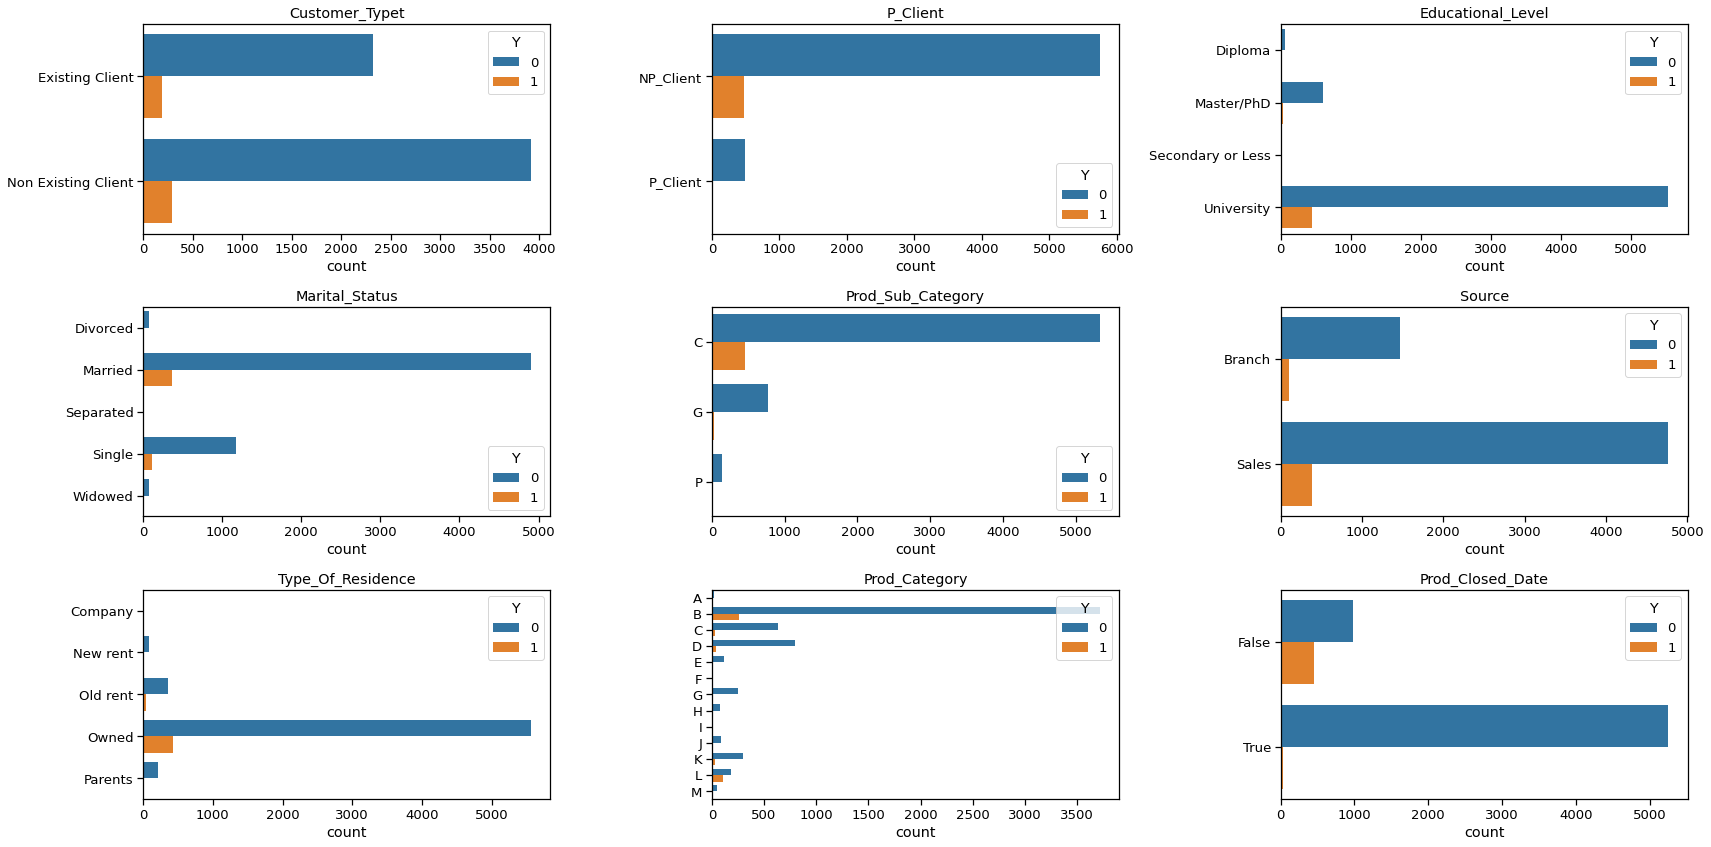

In [118]:
# categories stats

f, axes = plt.subplots(3, 3, figsize=(24,12))

sns.countplot(y=df.Customer_Type.values,hue=df.Y,ax=axes[0][0]).set(title='Customer_Typet')
sns.countplot(y=df.P_Client.values,hue=df.Y,ax=axes[0][1]).set(title='P_Client')
sns.countplot(y=df.Educational_Level.values,hue = df.Y,ax=axes[0][2]).set(title='Educational_Level')
sns.countplot(y=df.Marital_Status.values,hue = df.Y,ax=axes[1][0]).set(title='Marital_Status')
sns.countplot(y=df.Prod_Sub_Category.values,hue = df.Y,ax=axes[1][1]).set(title='Prod_Sub_Category')
sns.countplot(y=df.Source.values,hue = df.Y,ax=axes[1][2]).set(title='Source')
sns.countplot(y=df.Type_Of_Residence.values,hue = df.Y,ax=axes[2][0]).set(title='Type_Of_Residence')
sns.countplot(y=df.Prod_Category.values,hue = df.Y,ax=axes[2][1]).set(title='Prod_Category')
sns.countplot(y=df.Prod_Closed_Date.values,hue = df.Y,ax=axes[2][2]).set(title='Prod_Closed_Date')


plt.tight_layout()

Description of figures above, in the grand scheme of things :

- The credit demands that correspond to "University" education level are representing the majority compared to other education levels since university students aren't capable tp pay the university fees without having a credit.
- For the marital status, we can say that married people have more responsabilities that requiere finacial capital ( Home, car, marriage fees...etc)
- According to our dataset, we perceive that Sales (financial source) category are those with more interest in having credit than Branch category, but the odds of acceptng/rejecting the credit remain almost the same.
- In terms of Product category, we notice that product B and L corresponds to the most accepted credits. However, the ratio accepted/rejected are starkly different in such a way that L is accepted more than B. We can ostensibly assume that product L helps more in having a credit than other ones. 



## Features engineering

In this step, we will :

- detect outliers.
- add new variables (example : age from birthday date)
- encode categories (replace categories labels with numbers)

### Outliers
The simplest way to detect an outlier is by graphing the features or the data points. Visualization is one of the best and easiest ways to have an inference about the overall data and the outliers. Scatter plots and box plots are the most preferred visualization tools to detect outliers. Based on the previous distributions of Number_Of_Dependant, Net_Annual_Income, Years_At_Business, we assumed the presence of some outliers. To confirm this assumption, we will visualize these variables with scatter and box plots. 

In [119]:
df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,6714,0,Non Existing Client,1971-02-09,2012-01-18,NP_Client,University,Married,3.0,10,36.0,3.0,C,2012-01-23,Sales,Owned,1,True,B
1,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36.0,1.0,C,2012-02-14,Sales,Owned,1,True,B
2,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18.0,2.0,C,2011-06-30,Sales,Parents,1,True,G
3,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36.0,1.0,C,2012-04-04,Sales,Owned,1,True,B
4,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36.0,1.0,C,2011-07-09,Sales,New rent,1,False,L


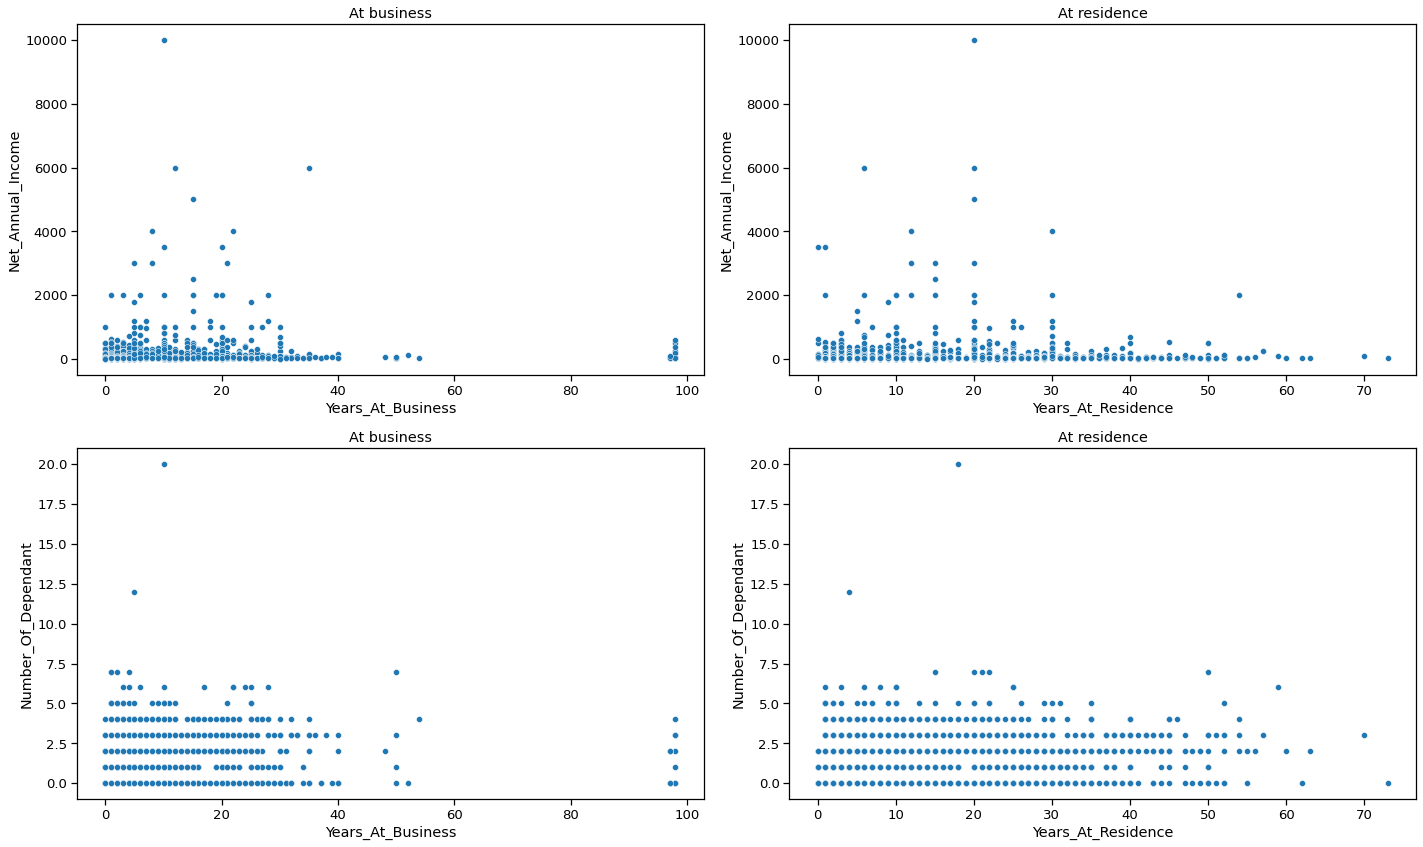

In [120]:
# using scatter plots + Number_Of_Dependant, Years_At_Residenc, Net_Annual_Income, Years_At_Business

f, ax = plt.subplots(2,2,figsize=(20,12 ))

sns.scatterplot(df.Years_At_Business,df.Net_Annual_Income, ax = ax[0][0]).set(title='At business')
sns.scatterplot(df.Years_At_Residence,df.Net_Annual_Income,ax = ax[0][1]).set(title='At residence')

sns.scatterplot(df.Years_At_Business,df.Number_Of_Dependant, ax = ax[1][0]).set(title='At business')
sns.scatterplot(df.Years_At_Residence,df.Number_Of_Dependant,ax = ax[1][1]).set(title='At residence')

plt.tight_layout()

- Net_Annual_Income : one to three outliers  (above 6000)
- Number_Of_Dependant : two outliers (above 10)
- Years_At_Business : seven outliers near 100 ( Years at business takes values near 100 which is not the case in real life, so we assume that some clients are companies )

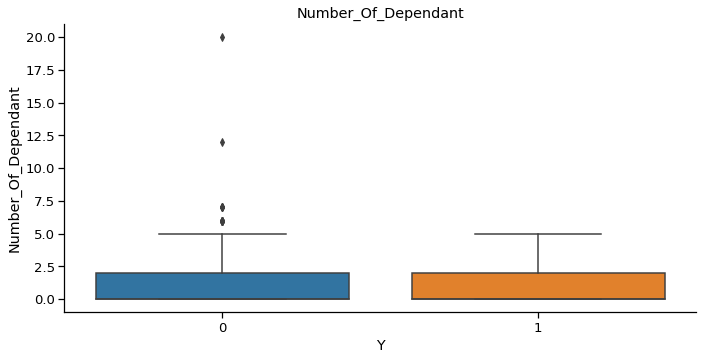

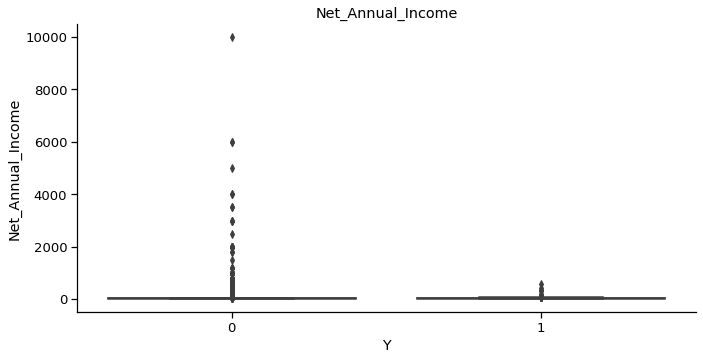

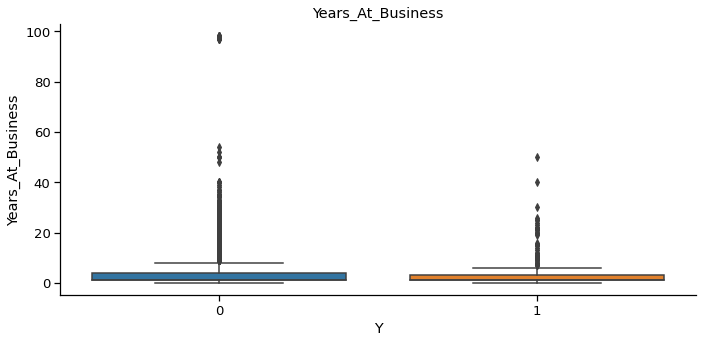

In [121]:
# using box plots + Number_Of_Dependant, Years_At_Residenc, Net_Annual_Income, Years_At_Business

sns.catplot(
    data=df,
    x='Y',
    y= 'Number_Of_Dependant',
    kind='box',
    height=5, # make the plot 5 units high
    aspect=2).set(title='Number_Of_Dependant')

sns.catplot(
    data=df,
    x='Y',
    y= 'Net_Annual_Income',
    kind='box',
    height=5, # make the plot 5 units high
    aspect=2).set(title='Net_Annual_Income')

sns.catplot(
    data=df,
    x='Y',
    y= 'Years_At_Business',
    kind='box',
    height=5, # make the plot 5 units high
    aspect=2).set(title='Years_At_Business')

plt.tight_layout()

The box plots confirm what we said earlier about the outliers noticed in the scatter plots. Removing outliers is not always the optimal solution, in this notebook we will work with them and recuce their effects by a robust scaling 

### Add new variables

- Add Age_Client column based on reference date taken from the last date when Prod_Closed_Date was available (not nan) which is 01-01-2014.
PS: the reference date is probably the year when this data was collected.
- By handeling  the column Customer_Open_Date we can create another column where the information on the customer's seniority is located.
- As for the Prod_Decision_Date column, we have information on the duration of the first contract for each client.
In the end, we manage to transform the date columns into useful numeric columns.



In [122]:
reference = datetime(2014, 1, 1)

df['Age_Client'] = reference - df['BirthDate']
df['Age_Client'] = df['Age_Client'].astype(str)
df['Age_Client'] = df['Age_Client'].map(lambda x: x.rstrip('days'))
df['Age_Client'] = df['Age_Client'].astype(int).apply(lambda x : x/365.25)
df['Age_Client'] = df['Age_Client']//1
df['Age_Client']

0       42.0
1       36.0
2       39.0
3       40.0
4       31.0
        ... 
6720    60.0
6721    31.0
6722    63.0
6723    30.0
6724    31.0
Name: Age_Client, Length: 6725, dtype: float64

In [123]:
df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category,Age_Client
0,6714,0,Non Existing Client,1971-02-09,2012-01-18,NP_Client,University,Married,3.0,10,36.0,3.0,C,2012-01-23,Sales,Owned,1,True,B,42.0
1,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36.0,1.0,C,2012-02-14,Sales,Owned,1,True,B,36.0
2,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18.0,2.0,C,2011-06-30,Sales,Parents,1,True,G,39.0
3,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36.0,1.0,C,2012-04-04,Sales,Owned,1,True,B,40.0
4,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36.0,1.0,C,2011-07-09,Sales,New rent,1,False,L,31.0


In [124]:
df['Anciennete_Client'] = reference - df['Customer_Open_Date']
df['Anciennete_Client'] = df['Anciennete_Client'].astype(str)
df['Anciennete_Client'] = df['Anciennete_Client'].map(lambda x: x.rstrip('days'))
df['Anciennete_Client'] = np.round(df['Anciennete_Client'].astype(int).apply(lambda x : x/365.25),2)
df['Anciennete_Client'] 

0       1.95
1       1.88
2       4.75
3       1.83
4       2.35
        ... 
6720    2.55
6721    2.53
6722    2.38
6723    1.96
6724    2.21
Name: Anciennete_Client, Length: 6725, dtype: float64

In [125]:
df['Duree_1er_Contrat'] = reference - df['Prod_Decision_Date']
df['Duree_1er_Contrat'] = df['Duree_1er_Contrat'].astype(str)
df['Duree_1er_Contrat'] = df['Duree_1er_Contrat'].map(lambda x: x.rstrip('days'))
df['Duree_1er_Contrat'] = np.round(df['Duree_1er_Contrat'].astype(int).apply(lambda x : x/365.25),2)
df['Duree_1er_Contrat']

0       1.94
1       1.88
2       2.51
3       1.74
4       2.48
        ... 
6720    2.55
6721    2.15
6722    2.38
6723    1.95
6724    2.19
Name: Duree_1er_Contrat, Length: 6725, dtype: float64

In [126]:
df.columns

Index(['Id_Customer', 'Y', 'Customer_Type', 'BirthDate', 'Customer_Open_Date',
       'P_Client', 'Educational_Level', 'Marital_Status',
       'Number_Of_Dependant', 'Years_At_Residence', 'Net_Annual_Income',
       'Years_At_Business', 'Prod_Sub_Category', 'Prod_Decision_Date',
       'Source', 'Type_Of_Residence', 'Nb_Of_Products', 'Prod_Closed_Date',
       'Prod_Category', 'Age_Client', 'Anciennete_Client',
       'Duree_1er_Contrat'],
      dtype='object')

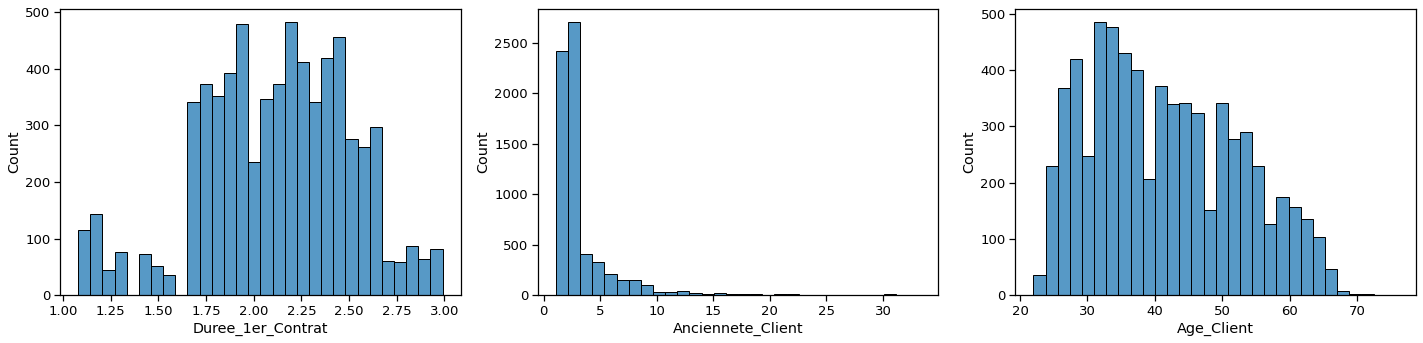

In [127]:
f, axes = plt.subplots(1, 3, figsize=(20,5))

sns.histplot(df.Duree_1er_Contrat, bins = 30, ax=axes[0])
sns.histplot(df.Anciennete_Client, bins = 30, ax=axes[1])
sns.histplot(df.Age_Client,  bins = 30, ax=axes[2])

f.tight_layout()

### Categories encoding
Among the different techniques of categories encoding such as Label encoding, One hot encoding..etc, we will use **the Mean encoding technique**. Unlike one hot encoding that increase the dimensionality of our data ( nb of variables) and label encoding, which gets the work done efficiently but in a random way, mean encoding tries to approach the problem more logically. In a nutshell, it uses the target variable as the basis to generate the new encoded feature based on the ratio of occurrence of the positive class in the target variable. 

In [128]:
df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category,Age_Client,Anciennete_Client,Duree_1er_Contrat
0,6714,0,Non Existing Client,1971-02-09,2012-01-18,NP_Client,University,Married,3.0,10,36.0,3.0,C,2012-01-23,Sales,Owned,1,True,B,42.0,1.95,1.94
1,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36.0,1.0,C,2012-02-14,Sales,Owned,1,True,B,36.0,1.88,1.88
2,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18.0,2.0,C,2011-06-30,Sales,Parents,1,True,G,39.0,4.75,2.51
3,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36.0,1.0,C,2012-04-04,Sales,Owned,1,True,B,40.0,1.83,1.74
4,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36.0,1.0,C,2011-07-09,Sales,New rent,1,False,L,31.0,2.35,2.48


In [129]:
# define categories

categories = ['Customer_Type','P_Client','Educational_Level', 'Marital_Status','Prod_Sub_Category','Source',
              'Type_Of_Residence','Prod_Category']
  

**Mean Encoding with additive smoothing regularisation**

We've read a few articles on common encoding techniques, one of which caught our attention: mean encoding (aka target, aka likelihood, aka impact), whereby each distinct value of categorical value is replaced with average value of target variable we're trying to predict.

After some googling and reading through amazing Kaggle kernels and forums, we've realized that:

- mean encoding as it is has high risk of overfitting, so some kind of regularisation is required
- there are several ways of doing this regularisation. In this notebook, we chose additive smoothing regularisation.

In [130]:
def encode_target_smooth(data, target, categ_variables, smooth):
  
    train_target = data.copy()
    code_map = dict()    # stores mapping between original and encoded values
    default_map = dict() # stores global average of each variable
    
    for v in categ_variables:
        prior = data[target].mean()
        n = data.groupby(v).size()
        mu = data.groupby(v)[target].mean()
        mu_smoothed = (n * mu + smooth * prior) / (n + smooth)
        
        train_target.loc[:, v] = train_target[v].map(mu_smoothed)        
        code_map[v] = mu_smoothed
        default_map[v] = prior        
    return train_target, code_map, default_map

In [131]:
df_target_smooth, target_map, default_map = encode_target_smooth(df, 'Y', categories, 500)
#If value of categorical variable has n observations that is lower than smooth, then the weighted average will be dominated by the global average.

In [132]:
# categories after mean encoding applied
df_target_smooth[categories].head()


,Customer_Type,P_Client,Educational_Level,Marital_Status,Prod_Sub_Category,Source,Type_Of_Residence,Prod_Category
0,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299
1,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299
2,0.076198,0.054774,0.074592,0.06977,0.078693,0.074072,0.071824,0.051242
3,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299
4,0.076198,0.075589,0.074592,0.06977,0.078693,0.074072,0.083357,0.182593


In [133]:
df_target_smooth[categories].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6725 entries, 0 to 6724
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Customer_Type      6725 non-null   category
 1   P_Client           6725 non-null   category
 2   Educational_Level  6725 non-null   category
 3   Marital_Status     6725 non-null   category
 4   Prod_Sub_Category  6725 non-null   category
 5   Source             6725 non-null   category
 6   Type_Of_Residence  6725 non-null   category
 7   Prod_Category      6725 non-null   category
dtypes: category(8)
memory usage: 54.4 KB


## Data Scaling

In [134]:
df_target_smooth.columns

Index(['Id_Customer', 'Y', 'Customer_Type', 'BirthDate', 'Customer_Open_Date',
       'P_Client', 'Educational_Level', 'Marital_Status',
       'Number_Of_Dependant', 'Years_At_Residence', 'Net_Annual_Income',
       'Years_At_Business', 'Prod_Sub_Category', 'Prod_Decision_Date',
       'Source', 'Type_Of_Residence', 'Nb_Of_Products', 'Prod_Closed_Date',
       'Prod_Category', 'Age_Client', 'Anciennete_Client',
       'Duree_1er_Contrat'],
      dtype='object')

In [135]:
# store only features of interest
features = categories + ['Y','Number_Of_Dependant','Years_At_Residence','Net_Annual_Income','Years_At_Business','Age_Client',
                         'Nb_Of_Products','Anciennete_Client','Duree_1er_Contrat','Prod_Closed_Date']
Processed_data = df_target_smooth[features]
Processed_data.head()

,Customer_Type,P_Client,Educational_Level,Marital_Status,Prod_Sub_Category,Source,Type_Of_Residence,Prod_Category,Y,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Age_Client,Nb_Of_Products,Anciennete_Client,Duree_1er_Contrat,Prod_Closed_Date
0,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299,0,3.0,10,36.0,3.0,42.0,1,1.95,1.94,True
1,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299,0,3.0,1,36.0,1.0,36.0,1,1.88,1.88,True
2,0.076198,0.054774,0.074592,0.06977,0.078693,0.074072,0.071824,0.051242,0,0.0,12,18.0,2.0,39.0,1,4.75,2.51,True
3,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299,0,2.0,10,36.0,1.0,40.0,1,1.83,1.74,True
4,0.076198,0.075589,0.074592,0.06977,0.078693,0.074072,0.083357,0.182593,1,3.0,3,36.0,1.0,31.0,1,2.35,2.48,False


In [136]:
Processed_data.to_csv('non_scaled.csv',index = False)

### Feature scaling

In [137]:
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

Processed_data['scaled_Number_Of_Dependant'] = rob_scaler.fit_transform(Processed_data['Number_Of_Dependant'].values.reshape(-1,1))
Processed_data['scaled_Years_At_Residence'] = rob_scaler.fit_transform(Processed_data['Years_At_Residence'].values.reshape(-1,1))
Processed_data['scaled_Net_Annual_Income'] = rob_scaler.fit_transform(Processed_data['Net_Annual_Income'].values.reshape(-1,1))
Processed_data['scaled_Years_At_Business'] = rob_scaler.fit_transform(Processed_data['Years_At_Business'].values.reshape(-1,1))
Processed_data['scaled_Age_Client'] = rob_scaler.fit_transform(Processed_data['Age_Client'].values.reshape(-1,1))
Processed_data['scaled_Nb_Of_Products'] = rob_scaler.fit_transform(Processed_data['Nb_Of_Products'].values.reshape(-1,1))
Processed_data['scaled_Anciennete_Client'] = rob_scaler.fit_transform(Processed_data['Anciennete_Client'].values.reshape(-1,1))
Processed_data['scaled_Duree_1er_Contrat'] = rob_scaler.fit_transform(Processed_data['Duree_1er_Contrat'].values.reshape(-1,1))


Processed_data.drop(['Number_Of_Dependant','Years_At_Residence','Net_Annual_Income','Years_At_Business','Age_Client',
                         'Nb_Of_Products','Anciennete_Client','Duree_1er_Contrat',], axis=1, inplace=True)

In [138]:
Processed_data.describe()

,Y,scaled_Number_Of_Dependant,scaled_Years_At_Residence,scaled_Net_Annual_Income,scaled_Years_At_Business,scaled_Age_Client,scaled_Nb_Of_Products,scaled_Anciennete_Client,scaled_Duree_1er_Contrat
count,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000,6725.000000
mean,0.072862,0.525651,0.197289,1.558239,1.087931,0.071351,0.086840,0.988600,-0.060950
std,0.259930,0.666319,0.768174,14.738615,2.417944,0.610182,0.295033,3.043853,0.719893
min,0.000000,0.000000,-0.769231,-2.249938,-0.333333,-1.000000,0.000000,-1.267327,-1.945455
25%,0.000000,0.000000,-0.461538,-1.000000,0.000000,-0.444444,0.000000,-0.336634,-0.545455
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.538462,0.000000,1.000000,0.555556,0.000000,0.663366,0.454545
max,1.000000,10.000000,4.846154,622.750000,32.333333,2.000000,2.000000,30.623762,1.527273


After scaling, we can notice that the mean ranges between 0 and 1.

In [139]:
# processed data ready for modeling
Processed_data.to_csv('Processed_data.csv', index=False)

# Approche I : Using Weighted Logistic Regression

In this project, we are handeling an imbalanced problem. In terms of evaluation metrics, we're choosing the ROC-AUC score. Note that, LR means Logistic regression and HT means hyperparameters tuning.



In [140]:
# define predictors and target

data = pd.read_csv('/content/Processed_data.csv')


In [88]:
data.head()

,Customer_Type,P_Client,Educational_Level,Marital_Status,Prod_Sub_Category,Source,Type_Of_Residence,Prod_Category,Y,Prod_Closed_Date,scaled_Number_Of_Dependant,scaled_Years_At_Residence,scaled_Net_Annual_Income,scaled_Years_At_Business,scaled_Age_Client,scaled_Nb_Of_Products,scaled_Anciennete_Client,scaled_Duree_1er_Contrat
0,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299,0,False,1.5,0.000000,0.000,0.666667,0.111111,0.0,-0.405941,-0.381818
1,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299,0,False,1.5,-0.692308,0.000,0.000000,-0.222222,0.0,-0.475248,-0.490909
2,0.076198,0.054774,0.074592,0.06977,0.078693,0.074072,0.071824,0.051242,0,False,0.0,0.153846,-1.125,0.333333,-0.055556,0.0,2.366337,0.654545
3,0.070732,0.075589,0.074592,0.06977,0.078693,0.074072,0.071143,0.067299,0,False,1.0,0.000000,0.000,0.000000,0.000000,0.0,-0.524752,-0.745455
4,0.076198,0.075589,0.074592,0.06977,0.078693,0.074072,0.083357,0.182593,1,False,1.5,-0.538462,0.000,0.000000,-0.500000,0.0,-0.009901,0.600000


In [141]:
# check the distribution
data['Y'].value_counts()/data.shape[0]

0    0.927138
1    0.072862
Name: Y, dtype: float64

Distributions look appealing. Majority label (0) is 93% in dataset whereas minority label (1) is just 7%. So, a accuracy of 93% can be achieved simply by predicting complete set as majority label i.e. 0. But that is no helpful since we are building classifier to classify minority label (important) from majority label.

In logistic regression, another technique comes handy to work with imbalance distribution. This is to use class-weights in accordance with the class distribution. Class-weights is the extent upon which the algorithm is punished for any wrong prediction of that class.

## Simple Logistic regression

In [214]:
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

# split dataset into x,y
X = data.drop('Y', axis = 1)
y = data['Y']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [144]:
# building simple logitic regression model with default weights

lr_simple = LogisticRegression(random_state=123,penalty='none', class_weight=None)

# fit it
lr_simple.fit(X_train,y_train)

# test
y_pred_simple = lr_simple.predict(X_test)

lr_simple_probs = lr_simple.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_simple_probs = lr_simple_probs[:, 1]
                       
# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_simple),2)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_simple),2)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_simple),2)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_simple),2)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_simple)}')


Accuracy : 0.94
Recall : 0.24
Precision : 0.72
AUC: 0.61
Confusion Matrix: 
[[1861   13]
 [ 110   34]]


That accuracy means nothing dont smile:). For minority class, above model is able to predict 34 correct out of 144 samples. For majority class, model got only 13 prediction wrong. Model is not doing a good job in predicting minority class. Nonetheless, with these default weights performance values, we got benchmark to measure subsequent model modifications. 

##Weighted Logistic Regression



In case be unbalanced label distribution, the best practice for weights is to use the inverse of the label distribution. In our set, label distribution is 7:93 so we can specify weights as inverse of label distribution. For majority class, will use weight of 7 and for minority class, will use weight of 93. So the penalty of wrong prediction of minority class would be 93 times more severe than wrong prediction of majority class. Moreover, with this class-weight values, we would expect our model to perform better then the default one i.e. previous model.

To specify weights we will make use of class_weight hyperparameter of Logistic-regression. The class_weight hyperparameter is a dictionary that defines weight of each label. Weights associated with classes in the form **{class_label: weight}**. If not given, all classes are supposed to have same weight value.

In [146]:
# define class weights
w = {0:7, 1:93}

# define model
lr_weighted = LogisticRegression(random_state=77, penalty = 'none',class_weight=w)

# fit it
lr_weighted.fit(X_train,y_train)

# test
y_pred_weighted = lr_weighted.predict(X_test)

lr_weighted_probs = lr_weighted.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_weighted_probs = lr_weighted_probs[:, 1]


# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_weighted),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_weighted),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_weighted),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_weighted),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_weighted)}')

Accuracy : 0.896
Recall : 0.896
Precision : 0.398
AUC: 0.896
Confusion Matrix: 
[[1679  195]
 [  15  129]]


With weighted-LR, Area-Under-Curve (AUC) increased drastically from 0.61 to 0.896 Recall score imporved from 0.24 to 0.896. Correct predictions for minority label increased as well. Though model has 195 wrong prediction in majority class, but custom weights have shown improvement in predicting minority class as expected ( 129/144 correct predictions).

## Weighted LR with GridSearch
In this part, will perform a grid search on different hyperparameters and will retain the one with a better performance score.

In [147]:
# define weight hyperparameter
w = [{0:7, 1:93}]
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"class_weight": w
                   ,"C": inv_reg
                   ,"fit_intercept" : [False,True]}

We will perform grid-search on above set of hyperparamters. This list can be as exhaustive as you want it to be. Can even make a simple function to create a large grid of different combinations. Since, ROC-AUC score is the evaluation metric here, so this score will be optimized.

In [148]:
# define weighted lr + weights gridsearch

weighted_lr_cv = LogisticRegression(random_state=13)

# define evaluation procedure : metric chosen ROC-AUC score ( this score will be optimized)
grid = GridSearchCV(weighted_lr_cv, hyperparam_grid, scoring="roc_auc", cv=5, n_jobs=-1, refit=True)

# fit on the whole dataset
grid.fit(X,y)

print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9301769143904555 with param: {'C': 1, 'class_weight': {0: 7, 1: 93}, 'fit_intercept': True}


In [149]:
# define lr with best params
lr_weighted_HT = LogisticRegression(random_state=113,C=1,fit_intercept = True, penalty='none',class_weight={0: 7, 1: 93} )

# fit it
lr_weighted_HT.fit(X_train,y_train)

# test
y_pred_weighted_HT = lr_weighted_HT.predict(X_test)

lr_weighted_HT_probs = lr_weighted_HT.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_weighted_HT_probs = lr_weighted_HT_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_weighted_HT),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_weighted_HT),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_weighted_HT),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_weighted_HT),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_weighted_HT)}')

Accuracy : 0.896
Recall : 0.896
Precision : 0.398
AUC: 0.896
Confusion Matrix: 
[[1679  195]
 [  15  129]]


With weighted-LR-HT, hyprerparameers tuning didnt imporve our model as we expeted.

## Penalized Weighted LR with GridSearch : Lasso, Ridge & Elasticnet

In this section, we add the penality argument. We tested Lasso, Ridge and Elasticnet penalities alogside with HT.

### Lasso Regularization


In [151]:
# define hyperparameters
w = [{0:7, 1:93}]
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"class_weight": w
                   ,"C": inv_reg
                   ,"fit_intercept" : [False,True]}

In [152]:
# logistic model classifier
lr_final_lasso = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_lasso,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9301769143904555 with param: {'C': 1, 'class_weight': {0: 7, 1: 93}, 'fit_intercept': True}


In [156]:
# define lr with best params
lr_final_lasso = LogisticRegression(random_state=123,C=1, penalty='l1',fit_intercept = True,solver = 'saga',class_weight={0: 7, 1: 93} )

# fit it
lr_final_lasso.fit(X_train,y_train)

# test
y_pred_final_lasso = lr_final_lasso.predict(X_test)

lr_final_lasso_probs = lr_final_lasso.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_lasso_probs = lr_final_lasso_probs[:, 1]

# performance
# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_lasso),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_lasso),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_lasso),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_lasso),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_lasso)}')

Accuracy : 0.856
Recall : 0.924
Precision : 0.323
AUC: 0.887
Confusion Matrix: 
[[1595  279]
 [  11  133]]


Lasso reguralization didnt improve our model that much, the roc-auc dropped a bit and the recall increased.

### Ridge Regularization

In [157]:
# define hyperparameters
w = [{0:7, 1:93}]
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"class_weight": w
                   ,"C": inv_reg
                   ,"fit_intercept" : [False,True]}

In [158]:
# logistic model classifier
lr_final_ridge = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_ridge,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9301769143904555 with param: {'C': 1, 'class_weight': {0: 7, 1: 93}, 'fit_intercept': True}


In [160]:
# define lr with best params
lr_final_ridge = LogisticRegression(random_state=7,C=1, penalty='l2',fit_intercept = True,class_weight={0: 7, 1: 93} )

# fit it
lr_final_ridge.fit(X_train,y_train)

# test
y_pred_final_ridge = lr_final_ridge.predict(X_test)

lr_final_ridge_probs = lr_final_ridge.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_ridge_probs = lr_final_ridge_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_ridge),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_ridge),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_ridge),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_ridge),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_ridge)}')

Accuracy : 0.896
Recall : 0.896
Precision : 0.399
AUC: 0.896
Confusion Matrix: 
[[1680  194]
 [  15  129]]


the auc score and the number of correct prediction for miniroty class increased.

### Elasticnet Regularization

In [161]:
# define hyperparameters
w = [{0:7, 1:93}]
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
l1_ratio = [0.001,0.01,0.1,0.2,0.5,0.8]
hyperparam_grid = {"class_weight": w
                   ,"l1_ratio" : l1_ratio #if l1_ratio = 1 lasso, if l1_ratio = 0 ridge
                   ,"C": inv_reg
                   ,"fit_intercept": [True, False]  }

In [162]:
# logistic model classifier
lr_final_elastic = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_elastic,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9301769143904555 with param: {'C': 1, 'class_weight': {0: 7, 1: 93}, 'fit_intercept': True, 'l1_ratio': 0.001}


In [164]:
# define lr with best params
lr_final_elastic = LogisticRegression(random_state=1523,C=1,fit_intercept=True, penalty='elasticnet',l1_ratio=0.001, solver = 'saga',class_weight={0: 7, 1: 93} )

# fit it
lr_final_elastic.fit(X_train,y_train)

# test
y_pred_final_elastic = lr_final_elastic.predict(X_test)

lr_final_elastic_probs = lr_final_elastic.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_elastic_probs = lr_final_elastic_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_elastic),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_elastic),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_elastic),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_elastic),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_elastic)}')

Accuracy : 0.856
Recall : 0.924
Precision : 0.323
AUC: 0.887
Confusion Matrix: 
[[1595  279]
 [  11  133]]


## ROC-Curve visualisation

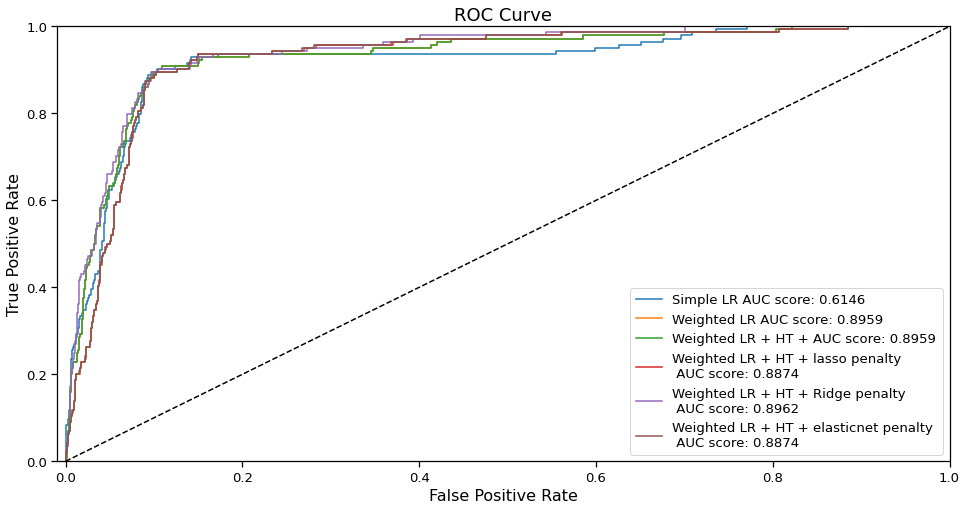

In [165]:
fpr_lr_simple, tpr_lr_simple, threshold = roc_curve(y_test, lr_simple_probs)
fpr_lr_weighted, tpr_lr_weighted, threshold_weighted = roc_curve(y_test, lr_weighted_probs)
fpr_lr_weighted_HT, tpr_lr_weighted_HT, threshold_weighted_HT = roc_curve(y_test, lr_weighted_HT_probs)
fpr_lr_final_lasso, tpr_lr_final_lasso, threshold_lasso = roc_curve(y_test, lr_final_lasso_probs)
fpr_lr_final_ridge, tpr_lr_final_ridge, threshold_ridge = roc_curve(y_test, lr_final_ridge_probs)
fpr_lr_final_elastic, tpr_lr_final_elastic, threshold_elastic = roc_curve(y_test, lr_final_elastic_probs)



def graph_roc_curve_multiple(fpr_lr_simple, tpr_lr_simple,fpr_lr_weighted, tpr_lr_weighted,fpr_lr_weighted_HT, tpr_lr_weighted_HT,fpr_lr_final_lasso, tpr_lr_final_lasso, fpr_lr_final_ridge, tpr_lr_final_ridge,fpr_lr_final_elastic, tpr_lr_final_elastic):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve', fontsize=18)
    
    plt.plot(fpr_lr_simple, tpr_lr_simple, label='Simple LR AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_simple)))

    plt.plot(fpr_lr_weighted, tpr_lr_weighted, label='Weighted LR AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_weighted)))
    plt.plot(fpr_lr_weighted, tpr_lr_weighted, label='Weighted LR + HT + AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_weighted_HT)))

    plt.plot(fpr_lr_final_lasso, tpr_lr_final_lasso, label='Weighted LR + HT + lasso penalty \n AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_final_lasso)))
    plt.plot(fpr_lr_final_ridge, tpr_lr_final_ridge, label='Weighted LR + HT + Ridge penalty \n AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_final_ridge)))
    plt.plot(fpr_lr_final_elastic, tpr_lr_final_elastic, label='Weighted LR + HT + elasticnet penalty \n AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_final_elastic)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
    plt.legend()
    
graph_roc_curve_multiple(fpr_lr_simple, tpr_lr_simple,fpr_lr_weighted, tpr_lr_weighted,fpr_lr_weighted_HT, tpr_lr_weighted_HT,fpr_lr_final_lasso, tpr_lr_final_lasso, fpr_lr_final_ridge, tpr_lr_final_ridge,fpr_lr_final_elastic, tpr_lr_final_elastic)
plt.show()

The figure above shows that :
- Weighted LR+HT+Ridge penalty is the est model in terms of roc-auc score (0.896). 
- The wighted models without any penalty performed well.

## Feature importance : Weighted LR + HT + Ridge penalty ( best model)

For further imporvement of the model, we can apply feature importances to have an idea about the features we can select and the "useless" features to get rid of them.

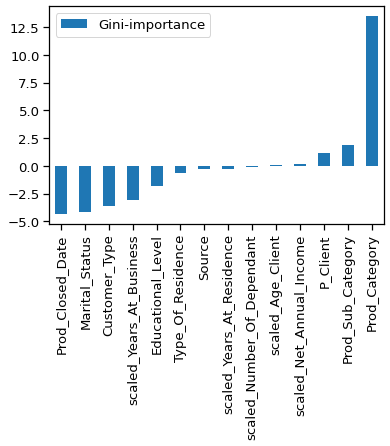

In [215]:
#importance = lr_final_ridge.coef_[0]
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, lr_final_ridge.coef_[0]):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

- The positive scores mean that the features corresponding contribute the most on predicting the postive class:1, while the negative scores corresponds to improrntant features in predicting the class:0.
- Based on the figure above, we can say that the features: 

**{'P_Client',  'scaled_Years_At_Business', 'scaled_Net_Annual_Income', 'scaled_Age_Client', 'scaled_Anciennete_Client', 'scaled_Number_Of_Dependant', 'scaled_Duree_1er_Contrat'}** are somehow "insignificant" to the model (weak impact on prediction). In the next step we will remove them to see if our model will achieve any improvement.

In [216]:
new_X = X.drop(['P_Client','scaled_Years_At_Business','scaled_Net_Annual_Income','scaled_Age_Client','scaled_Anciennete_Client',
                'scaled_Number_Of_Dependant','scaled_Duree_1er_Contrat'],axis = 1)

In [217]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=123)

In [218]:
# define hyperparameters
w = [{0:7, 1:93}]
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"class_weight": w
                   ,"C": inv_reg
                   ,"fit_intercept": [True, False]  }

In [219]:
# logistic model classifier
lr_final_ridge = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_ridge,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(new_X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9296810303913065 with param: {'C': 100, 'class_weight': {0: 7, 1: 93}, 'fit_intercept': True}


In [220]:
# define lr with best params
lr_final_ridge = LogisticRegression(random_state=123,C=100,fit_intercept=True, penalty='l2',class_weight={0: 7, 1: 93} )

# fit it
lr_final_ridge.fit(X_train,y_train)

# test
y_pred_final_ridge = lr_final_ridge.predict(X_test)

lr_final_ridge_probs = lr_final_ridge.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_ridge_probs = lr_final_ridge_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_ridge),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_ridge),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_ridge),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_ridge),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_ridge)}')

Accuracy : 0.897
Recall : 0.903
Precision : 0.401
AUC: 0.9
Confusion Matrix: 
[[1680  194]
 [  14  130]]


The AUC score improved slightely from 0.8962 to 0.90 , the recall also increased to 0.90. These numbers indicate a better model after feature selection.

In [221]:
best_model = lr_final_ridge

# Approche II : Using Resampling methods

### Undersampling

Before proceeding with the Random UnderSampling technique we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

### Random Under-Sampling

In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:
- The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)

- Once we determine how many instances are considered No credit (Y = "0") , we should bring the no-credit observations to the same amount as yes-credit  (assuming we want a 40/60 ratio), this will be equivalent to 600 cases of no and 400 cases of yes transactions.

- After implementing this technique, we have a sub-sample of our dataframe with a 40/60 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

In [174]:
# Lets shuffle the data before creating the subsamples

Processed_data = Processed_data.sample(frac=1)

# data for testing
testing_yes_Processed_data = Processed_data.loc[Processed_data['Y'] == 1][400:]
testing_no_Processed_data = Processed_data.loc[Processed_data['Y'] == 0][600:]

normal_distributed_testing = pd.concat([testing_yes_Processed_data, testing_no_Processed_data])

# Shuffle dataframe rows
testing_data = normal_distributed_testing.sample(frac=1, random_state=42)

# data for training
training_yes_Processed_data = Processed_data.loc[Processed_data['Y'] == 1][:400]
training_no_Processed_data = Processed_data.loc[Processed_data['Y'] == 0][:600]

normal_distributed_training = pd.concat([training_yes_Processed_data, training_no_Processed_data])

# Shuffle dataframe rows
training_data = normal_distributed_training.sample(frac=1, random_state=42)

print(training_data.shape,testing_data.shape)

(1000, 18) (5725, 18)


Distribution of the Classes in the subsample dataset
0    0.6
1    0.4
Name: Y, dtype: float64


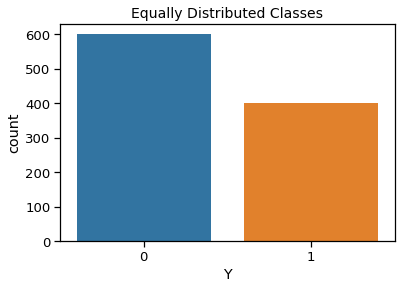

In [175]:
# Data for training
print('Distribution of the Classes in the subsample dataset')
print(training_data['Y'].value_counts()/len(training_data))



sns.countplot('Y', data=training_data)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Distribution of the Classes in the subsample dataset
0    0.984279
1    0.015721
Name: Y, dtype: float64


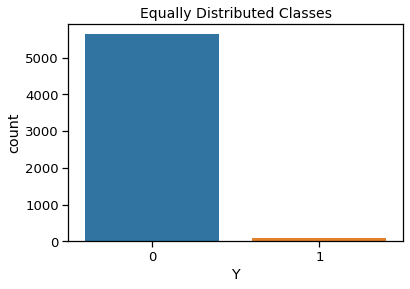

In [176]:
Data for testing
print('Distribution of the Classes in the subsample dataset')
print(testing_data['Y'].value_counts()/len(testing_data))



sns.countplot('Y', data=testing_data)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Modeling :
In this section we will train some classifiers and decide which classifier will be more effective in credit scoring. Before we have to split our data into training and testing sets and separate the features from the labels.


In [203]:
# Undersampling before cross validating (prone to overfit)
X = training_data.drop('Y', axis=1)
y = training_data['Y']


X_test = testing_data.drop('Y', axis=1)
y_test = testing_data['Y']


## Simple Logistic regression

In [179]:
# building simple logitic regression model with default weights

lr_simple = LogisticRegression(random_state=123,penalty='none', class_weight=None)

# fit it
lr_simple.fit(X,y)

# test
y_pred_simple = lr_simple.predict(X_test)

lr_simple_probs = lr_simple.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_simple_probs = lr_simple_probs[:, 1]
                       
# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_simple),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_simple),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_simple),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_simple),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_simple)}')


Accuracy : 0.906
Recall : 0.867
Precision : 0.129
AUC: 0.887
Confusion Matrix: 
[[5110  525]
 [  12   78]]


For minority class, above model is able to predict 78 correct out of 144 samples. For majority class, model got 525 prediction wrong. Model is  doing a good job in predicting minority class in comparison with the simple LR seen in the first approach above.

## Penalized Weighted LR with GridSearch : Lasso, Ridge & Elasticnet

### Lasso Regularization


In [180]:
# define hyperparameters
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"C": inv_reg
                   ,"fit_intercept": [True, False]  }

In [181]:
# logistic model classifier
lr_final_lasso = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_lasso,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9186666666666665 with param: {'C': 70, 'fit_intercept': True}


In [182]:
# define lr with best params
lr_final_lasso = LogisticRegression(random_state=123,C=70,fit_intercept=True, penalty='l1',solver = 'saga')

# fit it
lr_final_lasso.fit(X,y)

# test
y_pred_final_lasso = lr_final_lasso.predict(X_test)

lr_final_lasso_probs = lr_final_lasso.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_lasso_probs = lr_final_lasso_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_lasso),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_lasso),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_lasso),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_lasso),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_lasso)}')

Accuracy : 0.977
Recall : 0.256
Precision : 0.264
AUC: 0.622
Confusion Matrix: 
[[5571   64]
 [  67   23]]


The AUC and the recall dropped drastically. NO CANDY FOR U LASSO

### Ridge Regularization

In [183]:
# define hyperparameters
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"C": inv_reg,"fit_intercept": [True, False]  }

In [184]:
# logistic model classifier
lr_final_ridge = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_ridge,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9186666666666665 with param: {'C': 70, 'fit_intercept': True}


In [185]:
# define lr with best params
lr_final_ridge = LogisticRegression(random_state=123,C=70,fit_intercept=True, penalty='l2')

# fit it
lr_final_ridge.fit(X,y)

# test
y_pred_final_ridge = lr_final_ridge.predict(X_test)

lr_final_ridge_probs = lr_final_ridge.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_ridge_probs = lr_final_ridge_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_ridge),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_ridge),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_ridge),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_ridge),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_ridge)}')

Accuracy : 0.906
Recall : 0.867
Precision : 0.129
AUC: 0.887
Confusion Matrix: 
[[5110  525]
 [  12   78]]


The Ridge penalty impoves both auc and recall. The stranger thing what we coudnt explain is that Ridge gave same resuts as simple LR even if we set penalty argument to None ( no regularization).

### Elasticnet Regularization

In [186]:
# define hyperparameters
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
l1_ratio = [0.001,0.01,0.1,0.2,0.5,0.8]
hyperparam_grid = {"l1_ratio" : l1_ratio #if l1_ratio = 1 lasso, if l1_ratio = 0 ridge
                   ,"C": inv_reg
                   ,"fit_intercept": [True, False]  }

In [187]:
# logistic model classifier
lr_final_elastic = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_elastic,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9186666666666665 with param: {'C': 70, 'fit_intercept': True, 'l1_ratio': 0.001}


In [189]:
# define lr with best params
lr_final_elastic = LogisticRegression(random_state=1523,C=70,fit_intercept=True, penalty='elasticnet',l1_ratio=0.001, solver = 'saga')

# fit it
lr_final_elastic.fit(X,y)

# test
y_pred_final_elastic = lr_final_elastic.predict(X_test)

lr_final_elastic_probs = lr_final_elastic.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_elastic_probs = lr_final_elastic_probs[:, 1]

# performance
print(f'Accuracy : {accuracy_score(y_test,y_pred_final_elastic)}')
print(f'Recall : {recall_score(y_test,y_pred_final_elastic)}')
print(f'Precision : {precision_score(y_test,y_pred_final_elastic)}')
print(f'AUC: {roc_auc_score(y_test, y_pred_final_elastic)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_elastic)}')

Accuracy : 0.977467248908297
Recall : 0.23333333333333334
Precision : 0.25925925925925924
AUC: 0.6113427979887608
Confusion Matrix: 
[[5575   60]
 [  69   21]]


the model's performance dropped alot after elasticnet regularization.

## ROC-Curve visualisation

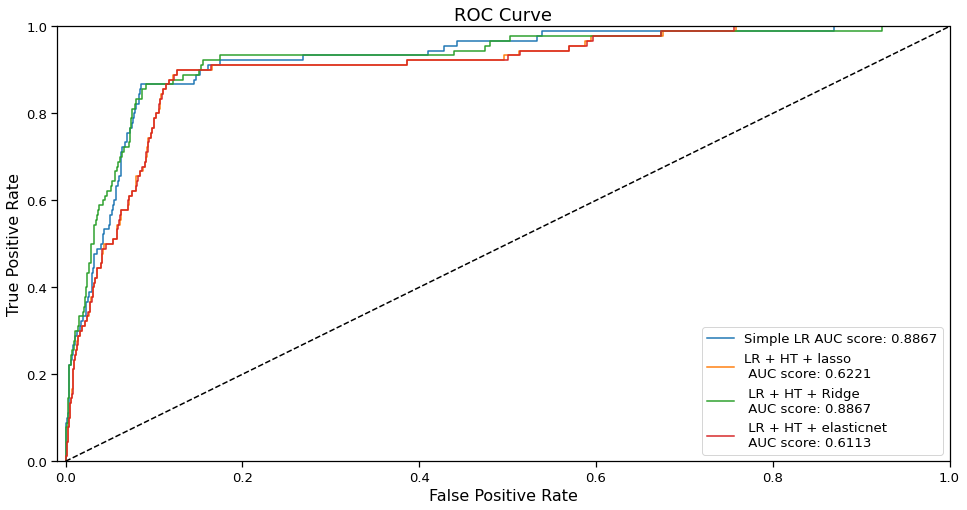

In [192]:
fpr_lr_simple, tpr_lr_simple, threshold = roc_curve(y_test, lr_simple_probs)
fpr_lr_final_lasso, tpr_lr_final_lasso, threshold_lasso = roc_curve(y_test, lr_final_lasso_probs)
fpr_lr_final_ridge, tpr_lr_final_ridge, threshold_ridge = roc_curve(y_test, lr_final_ridge_probs)
fpr_lr_final_elastic, tpr_lr_final_elastic, threshold_elastic = roc_curve(y_test, lr_final_elastic_probs)



def graph_roc_curve_multiple(fpr_lr_simple, tpr_lr_simple,fpr_lr_final_lasso, tpr_lr_final_lasso, fpr_lr_final_ridge, tpr_lr_final_ridge,fpr_lr_final_elastic, tpr_lr_final_elastic):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve', fontsize=18)
    
    plt.plot(fpr_lr_simple, tpr_lr_simple, label='Simple LR AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_simple)))

    plt.plot(fpr_lr_final_lasso, tpr_lr_final_lasso, label='LR + HT + lasso  \n AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_final_lasso)))
    plt.plot(fpr_lr_final_ridge, tpr_lr_final_ridge, label=' LR + HT + Ridge  \n AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_final_ridge)))
    plt.plot(fpr_lr_final_elastic, tpr_lr_final_elastic, label=' LR + HT + elasticnet  \n AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred_final_elastic)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
    plt.legend()
    
graph_roc_curve_multiple(fpr_lr_simple, tpr_lr_simple,fpr_lr_final_lasso, tpr_lr_final_lasso, fpr_lr_final_ridge, tpr_lr_final_ridge,fpr_lr_final_elastic, tpr_lr_final_elastic)
plt.show()

From the Roc_curve we can notice that :
- Simple LR and LR with Ridge penalty are the best models in terms of roc auc score.
- Lasso and elasticnet regularization didnt go well in this case.

## Feature importance :  LR + HT + Ridge penalty ( best model)

For further imporvement of the model, we can apply feature importances to have an idea about the features we can select and the "useless" features to get rid of them.

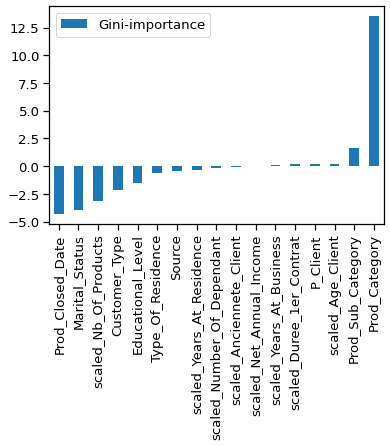

In [195]:
#importance = lr_final_ridge.coef_[0]
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, lr_final_ridge.coef_[0]):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

- The positive scores mean that the features corresponding contribute the most on predicting the postive class:1, while the negative scores corresponds to improrntant features in predicting the class:0.
- Based on the figure above, we can say that the features: 

**{''scaled_Years_At_Business', 'scaled_Net_Annual_Income', 'scaled_Anciennete_Client'}** are somehow "insignificant" to the model (weak impact on prediction). In the next step we will remove them to see if our model will achieve any improvement.

In [210]:
new_X = X.drop(['scaled_Years_At_Business','scaled_Net_Annual_Income','scaled_Anciennete_Client'],axis = 1)
X_test = X_test.drop(['scaled_Years_At_Business','scaled_Net_Annual_Income','scaled_Anciennete_Client'],axis = 1)

In [211]:
# define hyperparameters
inv_reg = [0.01, 0.1, 1, 10,30, 50, 70, 100, 1000]
hyperparam_grid = {"C": inv_reg
                   ,"fit_intercept": [True, False]  }

In [212]:
# logistic model classifier
lr_final_ridge = LogisticRegression(random_state=123)
# define evaluation procedure
grid = GridSearchCV(lr_final_ridge,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(new_X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9176666666666666 with param: {'C': 70, 'fit_intercept': True}


In [213]:
# define lr with best params
lr_final_ridge = LogisticRegression(random_state=123,C=70,fit_intercept=True, penalty='l2')

# fit it
lr_final_ridge.fit(new_X,y)

# test
y_pred_final_ridge = lr_final_ridge.predict(X_test)

lr_final_ridge_probs = lr_final_ridge.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_final_ridge_probs = lr_final_ridge_probs[:, 1]

# performance
print(f'Accuracy : {np.round(accuracy_score(y_test,y_pred_final_ridge),3)}')
print(f'Recall : {np.round(recall_score(y_test,y_pred_final_ridge),3)}')
print(f'Precision : {np.round(precision_score(y_test,y_pred_final_ridge),3)}')
print(f'AUC: {np.round(roc_auc_score(y_test, y_pred_final_ridge),3)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_final_ridge)}')

Accuracy : 0.905
Recall : 0.867
Precision : 0.128
AUC: 0.886
Confusion Matrix: 
[[5104  531]
 [  12   78]]


The model performances didnt improve, the model shows more wron predictions for the majority class while the predictions stats for minority class stays the same.

# Conclusion :

In this notebook, we tried to predict if the credit will be garanted or not based on imbalanced data. First, we cleaned the data and tried to create new features in feature engineering section. after, we scaled the data to avoid the fact that the range of values in our data varies widely and also to make the models work better. In the modeling step, we used two approaches, the first using weights method which is implemented in Logistic regression model with a ratio of 7:93 to balance the data. for the second approach, we used Random undersampling method to split the data into 400:600 obervations ratio (class 1 : class 0) for training process and 90:the rest (.resp), for the testing step. In other words, we trained our model on balanced data and we test it on imblanced data afterwards. The main objectif is to deal with the problem of imbalanced data.
The two approachs worked fine, we noticed that Logistic regression with Ridge penalty was the better in both approaches. In terms of ROC-AUC score, the weights approach resulted in a score of 0.90 while the undersampling approch score was 0.889. These numbers dont mean that the first approach is always better than the second, because it always depends on the data. Besides, we could try oversampling technique, but we think that the notebook content is way enough as tackle the imblanacing problem.

# Pickle the best model 

we pickled the best model in the whole analysis for any testing purposes

In [224]:
import pickle

pickle.dump(best_model, open("/content/best_model.pkl", "wb"))